In [1]:
%matplotlib inline


#  Computer Vision için Transfer Learning

- **convnet'te ince ayar yapma**: Rastgele başlatma yerine,
    ağı önceden eğitilmiş bir ağ ile başlatın,
    convnet imagenet 1000 veri setinde eğitildi. 
- **Sabit özellik çıkarıcı olarak ConvNet**: Burada ağırlıkları donduracağız
    son tamamen bağlı katman hariç tüm ağ için
    ağırlıkları donduracağız. Sonrasında son bağlantı katmanı istediğimiz bir görev için yeni full-connected katmanı ile değiştirilir. Rastgele ağırlıklarla ve sadece bu katman eğitilir.


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

## Verinin yüklenmesi

Veriyi yüklemek için her zaman yaptığımız `torchvision` ve `torch.utils.data` paketlerini kullanacağız.

Kullanacağımız veri kümesi imagenet'in çok küçük bir alt kümesi olan karınca ve arılar veri kümesidir. Küçük bir veri kümesi olduğundan dolayı sıfırdan eğitimle yüksek başarımlar alamayız. Ancak transfer learning yöntemi bu noktada bize yardımcı olacaktır.

Karıncalar ve arılar için yaklaşık 120 eğitim görselimiz var.
Her sınıf için 75 doğrulama görüntüsü vardır.

.. Note ::
    Verileri şu adresten indirin:
    (https://download.pytorch.org/tutorial/hymenoptera_data.zip)
    ve geçerli dizine çıkartın.



In [4]:
%%shell

# datayı indirelim.
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip .
# ve klasöre çıkartalım.
unzip hymenoptera_data.zip

--2023-02-14 05:20:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.36, 13.226.52.128, 13.226.52.51, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  88.6MB/s    in 0.5s    

2023-02-14 05:20:05 (88.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

--2023-02-14 05:20:05--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-02-14 05:20:05--
Total wall clock time: 1.1s
Downloaded: 1 files, 45M in 0.5s (88.6 MB/s)
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/001303

In [5]:
# Eğitim için Data augmentation ve normalization
# Doğrulama için sadece normalleştirme yapıyoruz.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Birkaç görüntüyü görselleştirelim
Verileri anlamak için birkaç eğitim görüntüsü görselleştirelim.

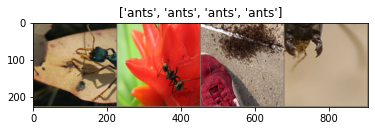

In [7]:
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Bir batch eğitim verisi alın
inputs, classes = next(iter(dataloaders['train']))

# batc'den bir ızgara yapın
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Modelimizi eğitelim

Şimdi bir modeli eğitmek için genel bir fonksiyon yazalım.

- Öğrenme oranını planlama
- En iyi modeli kaydetme

``scheduler`` parametresi bir LR zamanlayıcı nesnesidir.
``torch.optim.lr_scheduler``şeklinde kullanılır. hiperparametre tuning de kullanılır.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Her epoch'un bir eğitim ve doğrulama aşaması vardır
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # eğer veri train ise eğitim moduna geç.
            else:
                model.eval()   # değilse doğrulama modunda kal.

            running_loss = 0.0
            running_corrects = 0

            # veriler üzerinde yineleme yapalım
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parametre gradyanlarını sıfırlıyoruz.
                optimizer.zero_grad()

                # forward
                # eğer train de isek güncellemelere devam.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # eğitim aşamasındaysak bacwardla optimize edelim.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # istatistikler
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # en iyi modelimizi koplayalım
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'eğitim tamamlandı.. {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # en iyi modelin ağırlıklarını modele yükleyelim
    model.load_state_dict(best_model_wts)
    return model

### Model tahminlerini görselleştirme

Bir kaç görüntü için tahminleri görüntülemek adına genel bir fonksiyon yazalım




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'tahmin_edilen: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## convnet için finetuning 

Önceden eğitilmiş bir model yükleyin ve tamamen bağlı son katmanı sıfırlayın




In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Burada her çıktı örneğinin boyutu 2 olarak ayarlanmıştır.
# Alternatif olarak, nn.Linear(num_ftrs, len(class_names)) olarak genelleştirilebilir.
model_ft.fc = nn.Linear(num_ftrs, 2) # karınca ve arılar olduğundan dolayı çıktı örneğimizin boyutunu iki olarak ayarladık.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Tüm parametrelerin optimize edildiğini gözlemleyin
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# LR'yi her 7 çağda bir 0,1 kat azaltın
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Eğitim ve Değerlendirme

CPU'da yaklaşık 15-25 dakika sürüyor eğitim. GPU'da, bir
dakika.




In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8991 Acc: 0.6352
val Loss: 0.6545 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.7754 Acc: 0.7377
val Loss: 0.6816 Acc: 0.7647

Epoch 2/24
----------
train Loss: 0.7233 Acc: 0.7295
val Loss: 0.1815 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4588 Acc: 0.7910
val Loss: 0.2606 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5506 Acc: 0.7664
val Loss: 0.2183 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.6287 Acc: 0.7664
val Loss: 0.5296 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.4479 Acc: 0.8115
val Loss: 0.3552 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4009 Acc: 0.8279
val Loss: 0.3315 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3155 Acc: 0.8730
val Loss: 0.2640 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3344 Acc: 0.8607
val Loss: 0.2529 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.8484
val Loss: 0.2577 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3569 Acc: 0.8566
val Loss: 0.2213 Acc: 0.9150

Ep

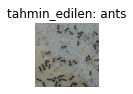

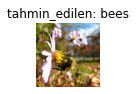

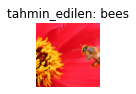

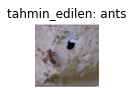

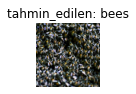

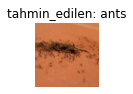

In [12]:
visualize_model(model_ft)

## Sabit özellik çıkarıcı olarak ConvNet

Burada son katman hariç tüm ağı dondurmamız gerekiyor. Parametreleri dondurmak için ``requires_grad = False`` kullanılırız ``backward()`` içinde gradyanlar hesaplanmaz

Bununla ilgili daha fazla bilgiyi belgelerde okuyabilirsiniz
(https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).




In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Yeni inşa edilen modüllerin parametrelerinde varsayılan olarak request_grad=True bulunur
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Yalnızca son katmanın parametrelerinin şu şekilde optimize edildiğini gözlemleyin
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# LR'yi her 7 çağda bir 0,1 kat azaltın
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Eğitin ve Değerlendirme


In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5001 Acc: 0.7705
val Loss: 0.2862 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5213 Acc: 0.7869
val Loss: 0.3220 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4824 Acc: 0.8238
val Loss: 0.2459 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3828 Acc: 0.7992
val Loss: 0.2147 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5407 Acc: 0.7500
val Loss: 0.1590 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4000 Acc: 0.8402
val Loss: 0.2425 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4774 Acc: 0.8074
val Loss: 0.1761 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4595 Acc: 0.8156
val Loss: 0.1827 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3572 Acc: 0.8648
val Loss: 0.1817 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3588 Acc: 0.8361
val Loss: 0.1978 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3513 Acc: 0.8607
val Loss: 0.1909 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3527 Acc: 0.8607
val Loss: 0.1879 Acc: 0.9412

Ep

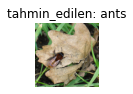

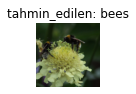

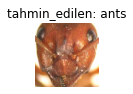

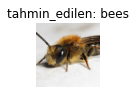

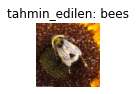

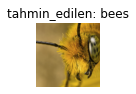

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()